In [19]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import math
import numpy as np

In [42]:
def mov_avg(data):
    data = np.array(data)
    window_width = 500
    cumsum_vec = np.cumsum(np.insert((data), 0, 0))
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

In [5]:
# Reads results csv files into df
def read_csv(path):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (pd.read_csv(file) for file in csv_files)
    full_df = pd.concat(df_list, ignore_index=True)
    full_df.columns = [c.replace(' ', '_') for c in full_df.columns]
    return full_df

In [23]:
# Separates and plots rewards
r_disc = -11  # reward for discarded product
r_nex = -50  # reward nonexistent


def plot_reward(df, title):
    # Multiple number of nonexistent issues by r_nex
    reward_nex = r_nex * df['issued_but_nonexistent']
    # Reward for issued but discarded
    reward_disc = r_disc * df['issued_but_discarded']
    # Reward for outdated products
    reward_out = -1 * df['num_outdates']

    # Remaining reward
    reward_rem = df['reward'] - reward_disc - reward_nex - reward_out

    plt.plot(mov_avg(reward_disc), label='discarded')
    plt.plot(mov_avg(reward_nex), label='non existing')
    plt.plot(mov_avg(reward_out), label='outdates')

    # Plot episode lines
    x = [*range(0, len(df), 435)]
    [plt.axvline(_x, linewidth=0.40, color='b') for _x in x]

    plt.legend(loc="lower right")

    plt.xlabel('Days')
    plt.ylabel('Reward')
    plt.title(title)

    plt.show()

In [ ]:
def plot_multi(dfs):
    r_nex = -50
    r_disc = -11

    cols = 2
    rows = math.ceil(len(dfs) / cols)
    width = 12
    if rows == 1:
        width = 6

    fig, axes = plt.subplots(rows, cols, figsize=(16, width), squeeze=False)
    dict_keys = [k for k in dfs.keys()]

    l = 0
    for i in range(rows):
        for j in range(cols):
            if len(dfs) == l:
                break
            else:
                key = dict_keys[l]
                # Reward non-existing
                reward_nex = r_nex * dfs[key]['issued_but_nonexistent']
                # Reward for issued but discarded
                reward_disc = r_disc * dfs[key]['issued_but_discarded']
                # Outdated product reward  = -1
                reward_out = -1 * dfs[key]['num_outdates']

                # Remaining reward
                # reward_rem = dfs[key]['reward'] - reward_disc - reward_nex - reward_out
                axes[i][j].plot(mov_avg(reward_disc), label='discarded')
                axes[i][j].plot(mov_avg(reward_nex), label='non-existing')
                axes[i][j].plot(mov_avg(reward_out), label='outdated')
                # axes[i][j].plot(savgol_filter(reward_rem, window_length=200, polyorder=2), label='compatible')
                axes[i][j].set(xlabel="Days", ylabel="Reward")
                axes[i][j].legend(loc='lower right')
                axes[i][j].set_title(dict_keys[l])

                # Plot episode lines
                x = [*range(0, len(dfs[key]), 982)]
                [axes[i][j].axvline(_x, linewidth=0.40, color='b') for _x in x]

            l += 1
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_multi_satisfied(dfs):
    cols = 2
    rows = math.ceil(len(dfs) / cols)
    width = 12
    if rows == 1:
        width = 6
    fig, axes = plt.subplots(rows, cols, figsize=(16, width), squeeze=False)
    dict_keys = [k for k in dfs.keys()]

    l = 0
    for i in range(rows):
        for j in range(cols):
            if len(dfs) == l:
                break
            else:
                key = dict_keys[l]
                # Number satisfied requests
                s = dfs[key]['num_units_requested'] - dfs[key]['issued_but_nonexistent'] - dfs[key][
                    'issued_but_discarded']
                r = dfs[key]['num_units_requested']
                perc = np.array(s / r)

                # Plot episode lines
                x = [*range(0, len(dfs[key]), 982)]
                [axes[i][j].axvline(_x, linewidth=0.40, color='b') for _x in x]

                axes[i][j].plot(mov_avg(perc), label='percentage satisifed')

                axes[i][j].set(xlabel="Days", ylabel="Percentage")
                axes[i][j].legend(loc='lower right')
                axes[i][j].set_title(dict_keys[l])
            l += 1
    plt.tight_layout()
    plt.show()

In [15]:
def plot_satisfied(df, title):
    s = df['num_units_requested'] - df['issued_but_nonexistent'] - df['issued_but_discarded']
    r = df['num_units_requested']
    perc = np.array(s / r)

    plt.plot(mov_avg(perc), label='satisfied')

    # Plot episode lines
    x = [*range(0, len(df), 982)]
    [plt.axvline(_x, linewidth=0.40, color='b') for _x in x]

    plt.legend(loc="lower right")

    plt.ylabel('Number units')
    plt.xlabel('Days')

    plt.title(title)

    plt.show()
    return

In [16]:
def plot_loss_multi(dfs, title):
    dict_keys = [k for k in dfs.keys()]

    for k in dict_keys:
        # Exclude first 70 days: these are for initialization. No updates are performed.
        df_loss = dfs[k].loc[dfs[k]['day_loss'] > 70]
        plt.plot(mov_avg(df_loss['day_loss']), label=k)

    # Plot episode lines
    x = [*range(0, len(dfs[dict_keys[0]]), 982)]
    [plt.axvline(_x, linewidth=0.40, color='b') for _x in x]

    plt.legend(loc='lower right')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Days')

    plt.tight_layout()
    plt.show()

### 1 Minor antigens

Experimenting with various number of minor antigens.

Max age of a unit = 35
Max lead time = 8

Input matrix has 44 columns (+1 for indicating current request)

output = number of actions

#### Model
```
input -> [64, tanh] -> [32, relu] -> [output, sigmoid]
```

Optimizer = adam
Loss = mse

Episode length = 365 days
10 episodes

LR = 0.001
gamma = 0.01
batch size = 50
epsilon: starts at 1, decays to 0.01 within each episode

Simulations consist of one run per antigen configuration. Different (non-fixed) random seed was used each time.

#### Major antigens + CcEeK

State space = 2<sup>8</sup> x 44 = 256 x 44
Output size = 256

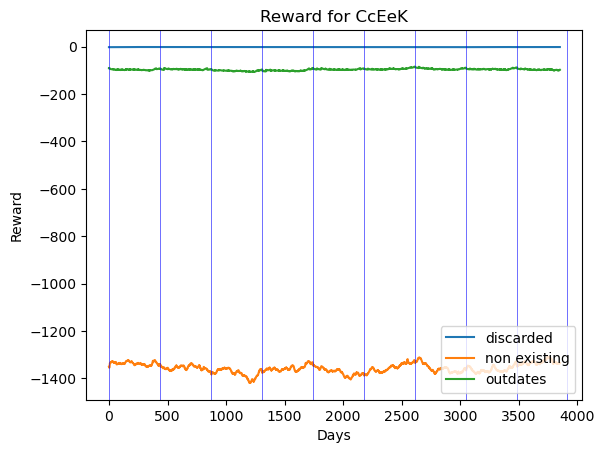

In [25]:
CcEeK = read_csv(
    'C:/Users/evani/OneDrive/AI leiden/Sanquin/Results/Results minor antigens/results/request_scratch/C_c_E_e_K/a0.1_g0.5_b50')
plot_reward(CcEeK, "Reward for CcEeK")

#### Major antigens + CcEe

State space = 2<sup>7</sup> x 44 = 128 x 44
Output size = 128

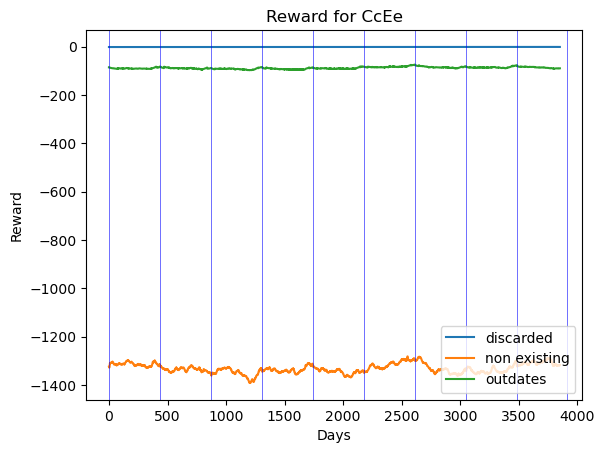

In [27]:
CcEe = read_csv(
    'C:/Users/evani/OneDrive/AI leiden/Sanquin/Results/Results minor antigens/results/request_scratch/C_c_E_e/a0.1_g0.5_b50')
plot_reward(CcEe, "Reward for CcEe")

#### Major antigens + CcE

State space = 2<sup>6</sup> x 44 = 64 x 44
Output size = 64

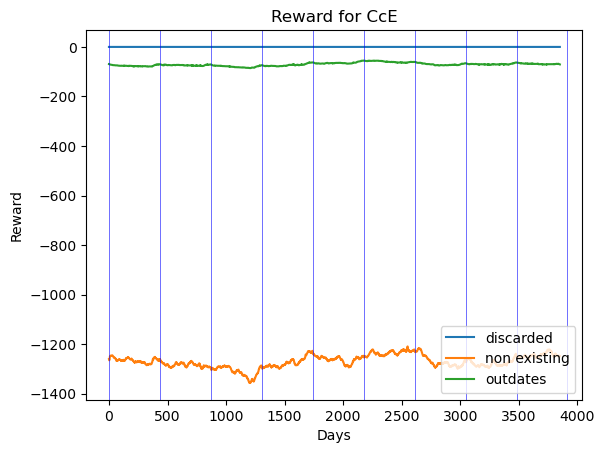

In [39]:
CcE = read_csv(
    'C:/Users/evani/OneDrive/AI leiden/Sanquin/Results/Results minor antigens/results/request_scratch/C_c_E/a0.1_g0.5_b50')
plot_reward(CcE, "Reward for CcE")

#### Major antigens + Cc

State space = 2<sup>5</sup> x 44 = 32 x 44
Output size = 32

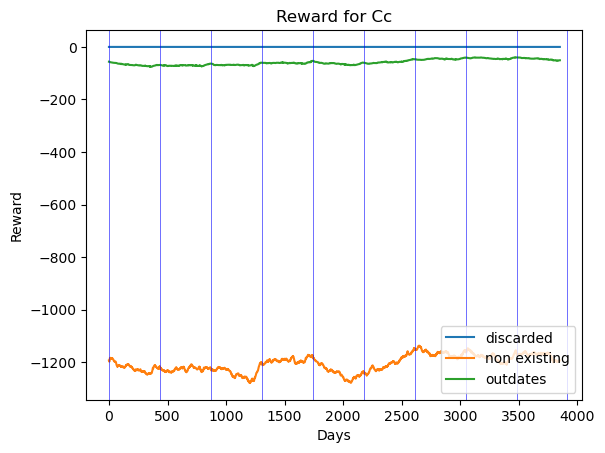

In [40]:
Cc = read_csv(
    'C:/Users/evani/OneDrive/AI leiden/Sanquin/Results/Results minor antigens/results/request_scratch/C_c/a0.1_g0.5_b50')
plot_reward(Cc, "Reward for Cc")

#### Major antigens + C

State space = 2<sup>4</sup> x 44 = 16 x 44
Output size = 16

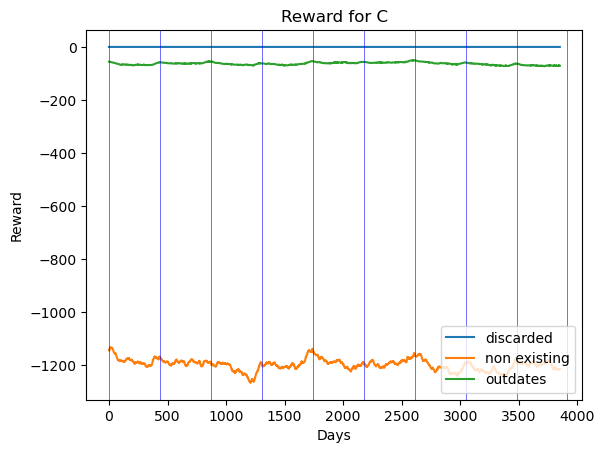

In [41]:
C = read_csv(
    'C:/Users/evani/OneDrive/AI leiden/Sanquin/Results/Results minor antigens/results/request_scratch/C/a0.1_g0.5_b50')
plot_reward(C, "Reward for C")

### Notes

All results look very similar. The model does not learn.
Next step: reduce problem space to only the major antigens. Input size = 8 x 44.

*During above simulations, the 'next_state' bug was not fixed yet. In the memories added to the experience replay buffer, the current state was equal to the next state.*
*Because the log_state function wasn't called properly, some data columns, such as 'number_units_requested', are lost.*
